## Decision Tree(`rpart`) Practice with *Used Car Prices* in R

# 0. Given codes from Kaggle

In [1]:
# 0. Given codes from Kaggle

# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] "used-car-price-dataset-competition-format"

# 1. Read Data

In [2]:
# 1. Read Data

x <- read.csv("../input/used-car-price-dataset-competition-format/X_train.csv")
y <- read.csv("../input/used-car-price-dataset-competition-format/y_train.csv")
x_test <- read.csv("../input/used-car-price-dataset-competition-format/X_test.csv")
y_test <- read.csv("../input/used-car-price-dataset-competition-format/test_label/y_test.csv")

# 1.1 Skim Data

In [3]:
# 1.1 Skim Data

head(x)

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145,39.8,2.2
2,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125,60.1,2.0
3,12342,audi,RS4,2019,Automatic,5151,Petrol,145,29.1,2.9
4,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30,57.6,2.0
5,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145,47.1,1.0
6,18964,merc,V Class,2019,Automatic,4170,Diesel,145,44.1,2.1


In [4]:
head(y)

,carID,price
,<int>,<int>
1,13207,31995
2,17314,7700
3,12342,58990
4,13426,12999
5,16004,16990
6,18964,40890


In [5]:
str(x)

'data.frame':	4960 obs. of  10 variables:
 $ carID       : int  13207 17314 12342 13426 16004 18964 17053 19021 17429 16726 ...
 $ brand       : chr  "hyundi" "vauxhall" "audi" "vw" ...
 $ model       : chr  " Santa Fe" " GTC" " RS4" " Scirocco" ...
 $ year        : int  2019 2015 2019 2016 2020 2019 2020 2019 2019 2012 ...
 $ transmission: chr  "Semi-Auto" "Manual" "Automatic" "Automatic" ...
 $ mileage     : int  4223 47870 5151 20423 3569 4170 3 101 6340 85843 ...
 $ fuelType    : chr  "Diesel" "Diesel" "Petrol" "Diesel" ...
 $ tax         : num  145 125 145 30 145 145 135 145 135 30 ...
 $ mpg         : num  39.8 60.1 29.1 57.6 47.1 44.1 64.2 34 52.3 57.7 ...
 $ engineSize  : num  2.2 2 2.9 2 1 2.1 1.8 3 2.5 1.2 ...


In [6]:
str(y)

'data.frame':	4960 obs. of  2 variables:
 $ carID: int  13207 17314 12342 13426 16004 18964 17053 19021 17429 16726 ...
 $ price: int  31995 7700 58990 12999 16990 40890 25990 41980 25490 3491 ...


In [7]:
summary(x)

     carID          brand              model                year     
 Min.   :12002   Length:4960        Length:4960        Min.   :1997  
 1st Qu.:13929   Class :character   Class :character   1st Qu.:2016  
 Median :15840   Mode  :character   Mode  :character   Median :2017  
 Mean   :15832                                         Mean   :2017  
 3rd Qu.:17766                                         3rd Qu.:2019  
 Max.   :19629                                         Max.   :2020  
 transmission          mileage         fuelType              tax       
 Length:4960        Min.   :     1   Length:4960        Min.   :  0.0  
 Class :character   1st Qu.:  5641   Class :character   1st Qu.:145.0  
 Mode  :character   Median : 19000   Mode  :character   Median :145.0  
                    Mean   : 24956                      Mean   :152.3  
                    3rd Qu.: 36702                      3rd Qu.:150.0  
                    Max.   :259000                      Max.   :580.0  
      

In [8]:
summary(y)

     carID           price       
 Min.   :12002   Min.   :   450  
 1st Qu.:13929   1st Qu.: 12000  
 Median :15840   Median : 18999  
 Mean   :15832   Mean   : 23470  
 3rd Qu.:17766   3rd Qu.: 30336  
 Max.   :19629   Max.   :145000  

※ Made sure there's no missing data.

# 1.2 Divide into Trainning and Valid Data

In [9]:
# 1.2 Divide into Trainning and Valid Data

n <- nrow(x)
idx <- sample(n, n * 0.8)

x["price"] <- y["price"]

x_train <- x[idx,-c(1:3)]                       # remove carID, brand, model
x_valid <- x[-idx,-c(1:3)]
x_test <- x_test[,-c(1:3)]

dim(x_train)
dim(x_valid)

head(x_train)

[1] 3968    8

[1] 992   8

,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>
685,2019,Semi-Auto,3238,Diesel,145,36.7,2.0,51000
2759,2019,Manual,8478,Diesel,145,53.3,1.5,15441
122,2016,Manual,44500,Diesel,30,62.7,1.6,8850
2784,2014,Manual,46152,Diesel,30,62.8,1.7,7498
2780,2017,Manual,26967,Petrol,30,54.3,1.0,10850
862,2015,Automatic,53101,Hybrid,10,64.2,1.8,17498


# 2. Fit Model

# 2.1 Fit Model

n= 3968 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 3968 1.077490e+12  23430.550  
   2) engineSize< 2.75 2985 2.901800e+11  17837.460  
     4) year< 2018.5 2055 9.052128e+10  13782.480  
       8) engineSize< 1.75 864 1.952353e+10   9817.212 *
       9) engineSize>=1.75 1191 4.755763e+10  16659.060  
        18) year< 2014.5 243 5.557380e+09   9929.198 *
        19) year>=2014.5 948 2.817345e+10  18384.110 *
     5) year>=2018.5 930 9.120360e+10  26797.650  
      10) engineSize< 1.9 381 1.684909e+10  19441.630 *
      11) engineSize>=1.9 549 3.943068e+10  31902.650 *
   3) engineSize>=2.75 983 4.103750e+11  40414.660  
     6) year< 2017.5 447 7.847805e+10  27206.740  
      12) mileage>=39354 174 1.523808e+10  18880.140 *
      13) mileage< 39354 273 4.348714e+10  32513.800  
        26) engineSize< 3.75 212 1.800128e+10  29077.050 *
        27) engineSize>=3.75 61 1.427950e+10  44457.920 *
     7) year>=2017.5 536 1.888875e+11  51429.470  
      14) m

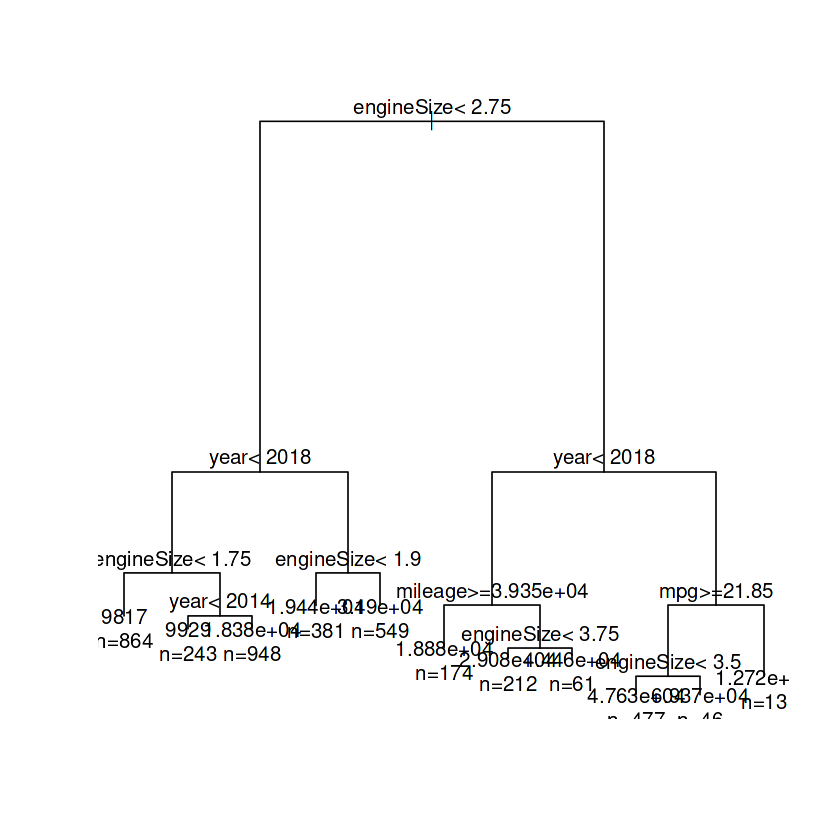

In [10]:
# 2. Fit Model

# 2.1 Fit Model

library(rpart)
model <- rpart(x_train$price ~ ., data = x_train)

model
plot(model, compress = TRUE)
text(model, use.n = TRUE)

,CP,nsplit,rel error,xerror,xstd
1,0.34982675,0,1.0000000,1.0006266,0.04811847
2,0.13272470,1,0.6501733,0.6510657,0.03320532
3,0.10065536,2,0.5174486,0.5282254,0.02987376
4,0.07101139,3,0.4167932,0.4304688,0.02908183
5,0.03241221,4,0.3457818,0.4113705,0.02720986
6,0.02175439,5,0.3133696,0.3443676,0.02284766
7,0.01839946,6,0.2916152,0.3269841,0.02285948
8,0.01833226,7,0.2732157,0.3154463,0.02181556
9,0.01283241,8,0.2548835,0.2939475,0.01966559
10,0.01040043,9,0.2420511,0.2705460,0.01762322


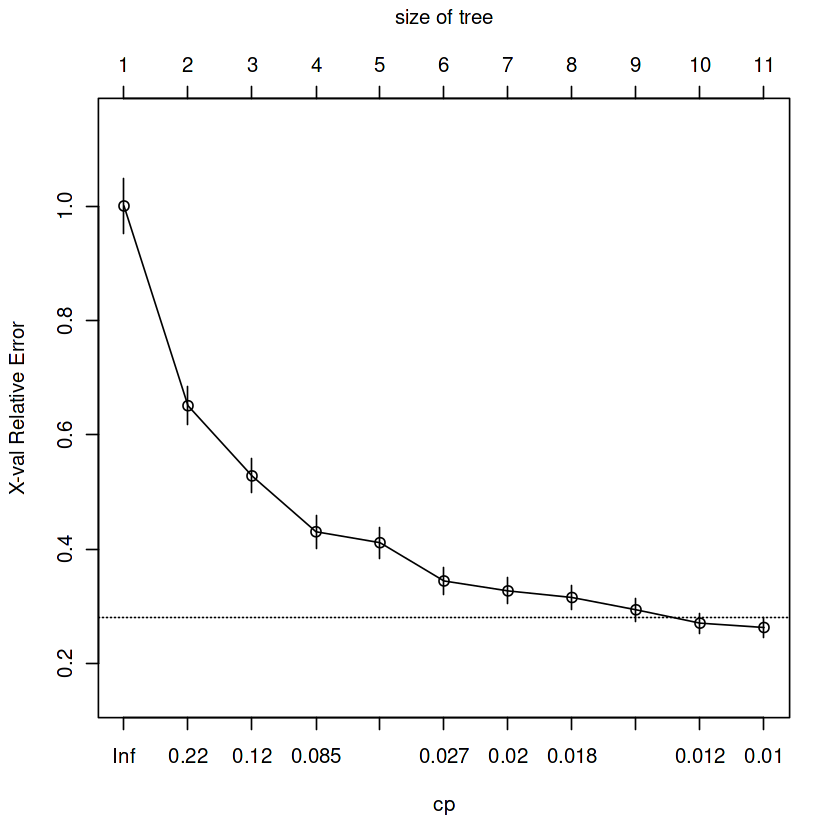

In [11]:
# summary(model)                               # too much results ……
model$cptable
plotcp(model)

There's no point that the xerror rises again, but I feel I should do something ……

# 2.2 Improve Model

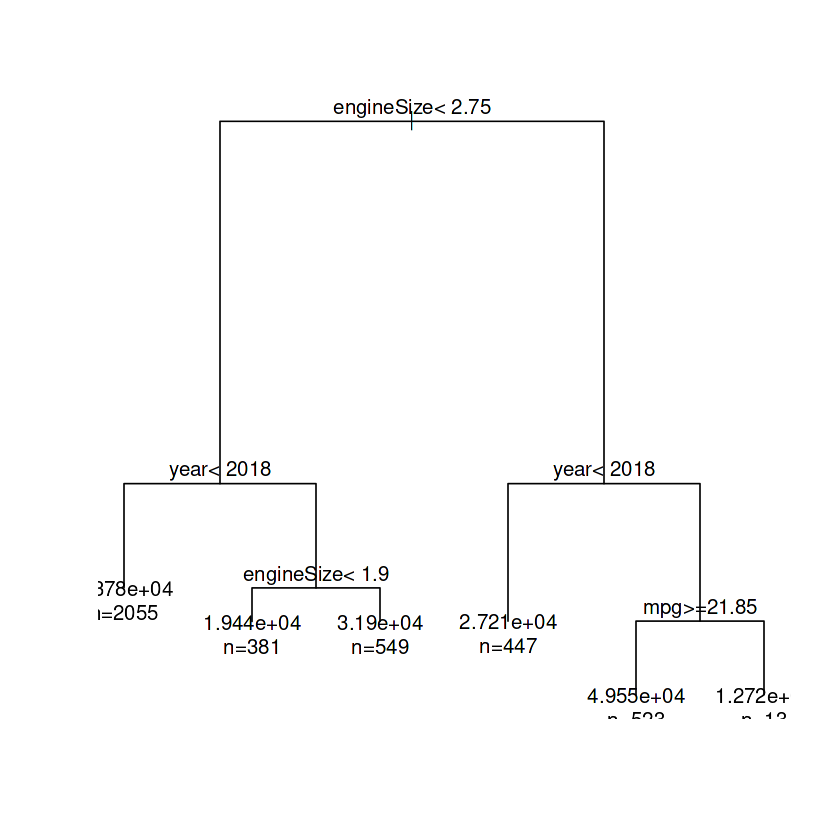

In [12]:
# 2.2 Improve Model
# I decided cutting cp at 0.025

model2 <- rpart(x_train$price ~ ., data = x_train, cp = 0.025)

plot(model2, compress = TRUE)
text(model2, use.n = TRUE)

,CP,nsplit,rel error,xerror,xstd
1,0.34982675,0,1.0000000,1.0005358,0.04811336
2,0.13272470,1,0.6501733,0.6507134,0.03319733
3,0.10065536,2,0.5174486,0.5395524,0.03019930
4,0.07101139,3,0.4167932,0.4406702,0.02943071
5,0.03241221,4,0.3457818,0.3871335,0.02378000
6,0.02500000,5,0.3133696,0.3537669,0.02383045


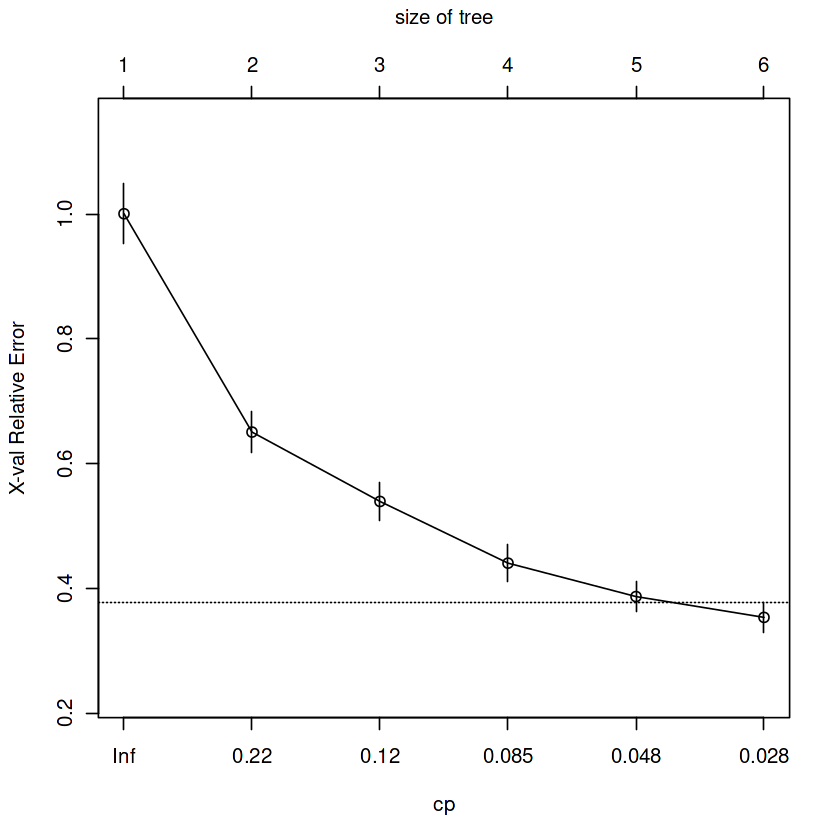

In [13]:
model2$cptable
plotcp(model2)

# 2.21 Compare 2 Models

In [14]:
# 2.21 Compare 2 Models

pred1 <- predict(model, newdata = x_test)
pred2 <- predict(model2, newdata = x_test)

summary(pred1); cor(pred1, y_test$price); sqrt(mean((pred1 - y_test$price)^2))
summary(pred2); cor(pred2, y_test$price); sqrt(mean((pred2 - y_test$price)^2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9817    9929   18384   23591   31903  127212 

[1] 0.8431885

[1] 8950.963

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13782   13782   13782   23549   31903  127212 

[1] 0.7950059

[1] 10092.61

Worse performance???

# 2.3 Improve Model 2

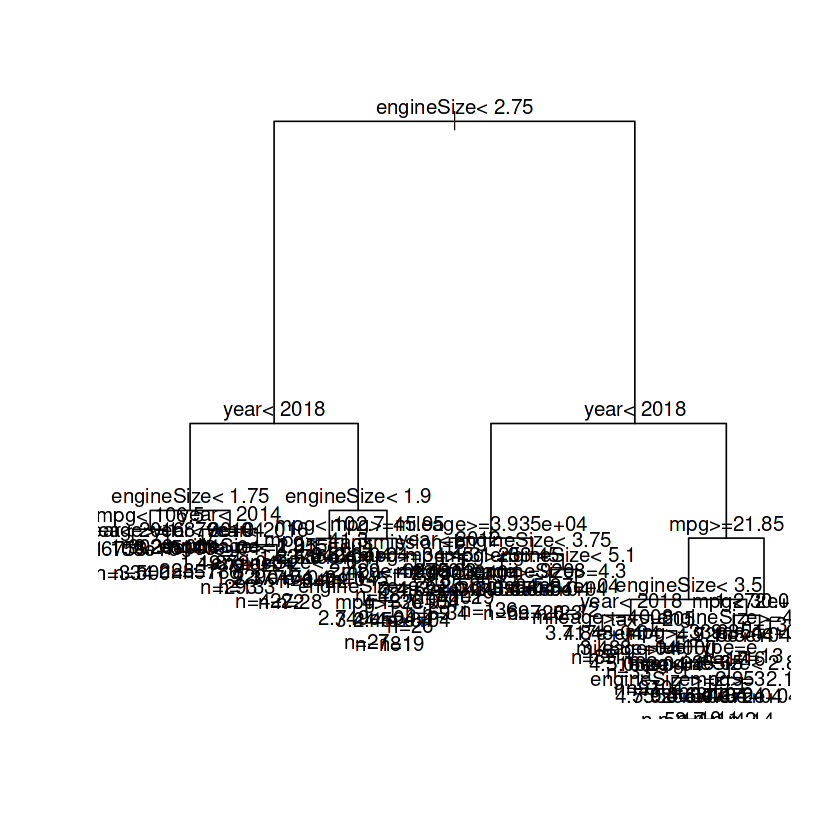

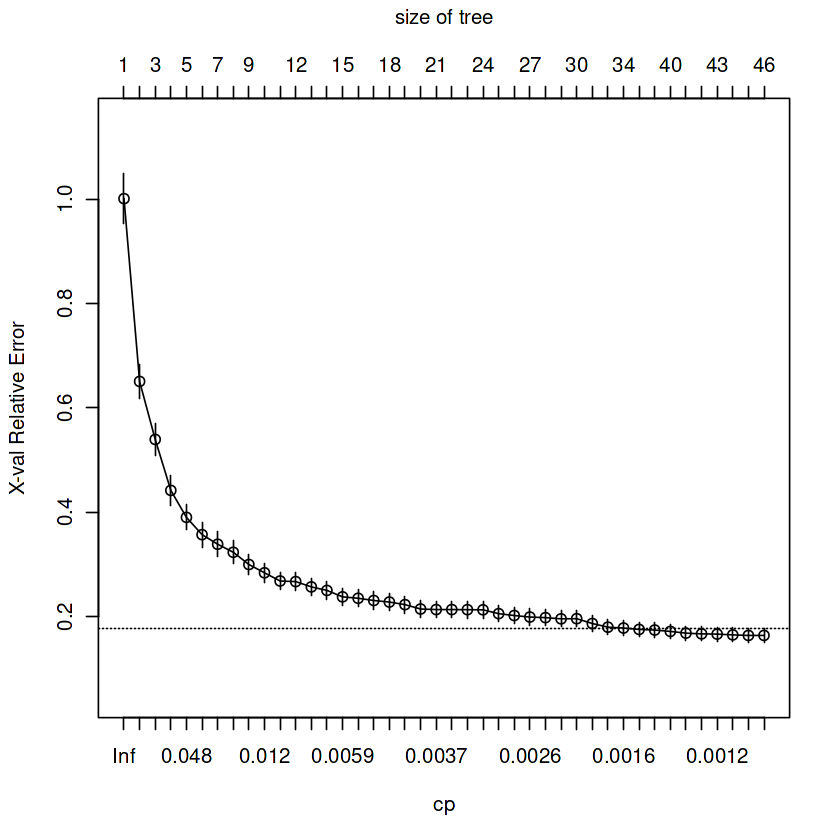

In [15]:
# 2.3 Improve Model 2

model3 <- rpart(x_train$price ~ ., data = x_train, cp = 0.001)

plot(model3, compress = TRUE)
text(model3, use.n = TRUE)

# model3$cptable                                    # skip because it has even 44 lines
plotcp(model3)

# 2.31 Compare 3 Models

In [16]:
# 2.31 Compare 3 Models

pred1 <- predict(model, newdata = x_test)
pred2 <- predict(model2, newdata = x_test)
pred3 <- predict(model3, newdata = x_test)

summary(pred1); cor(pred1, y_test$price); sqrt(mean((pred1 - y_test$price)^2))
summary(pred2); cor(pred2, y_test$price); sqrt(mean((pred2 - y_test$price)^2))
summary(pred3); cor(pred3, y_test$price); sqrt(mean((pred3 - y_test$price)^2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9817    9929   18384   23591   31903  127212 

[1] 0.8431885

[1] 8950.963

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13782   13782   13782   23549   31903  127212 

[1] 0.7950059

[1] 10092.61

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5103   11408   19294   23771   32442  127212 

[1] 0.9021107

[1] 7229.78

Model 3 is not overfitting yet!

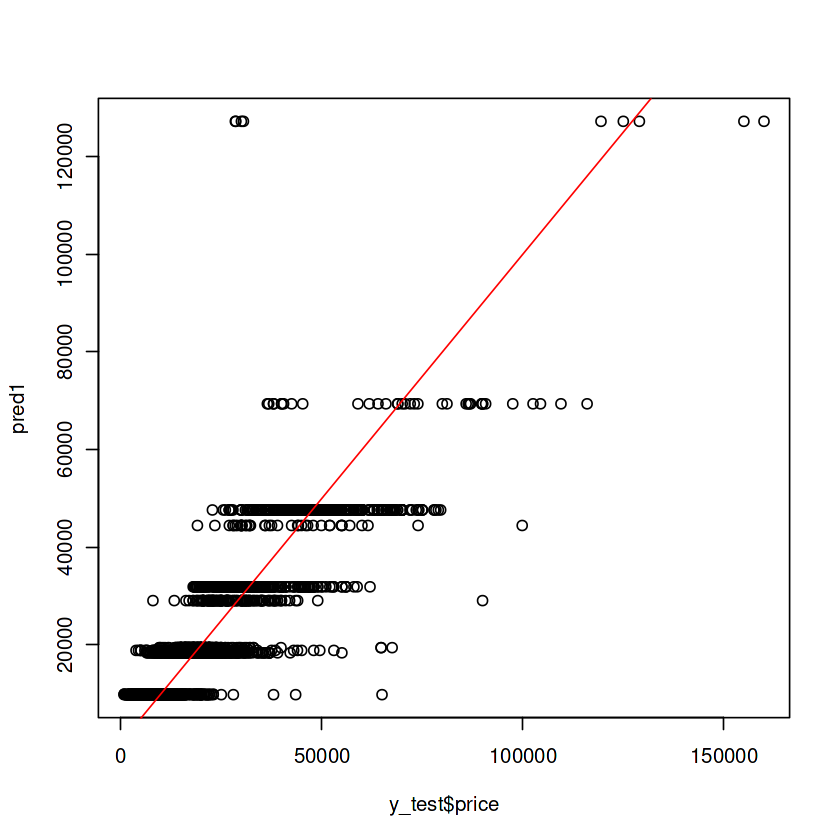

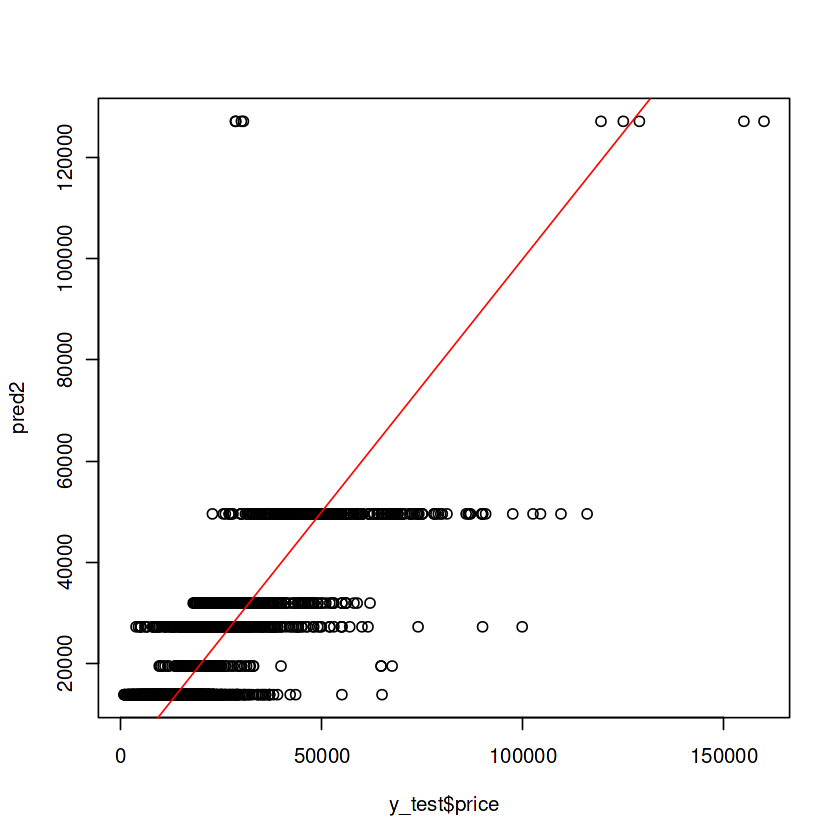

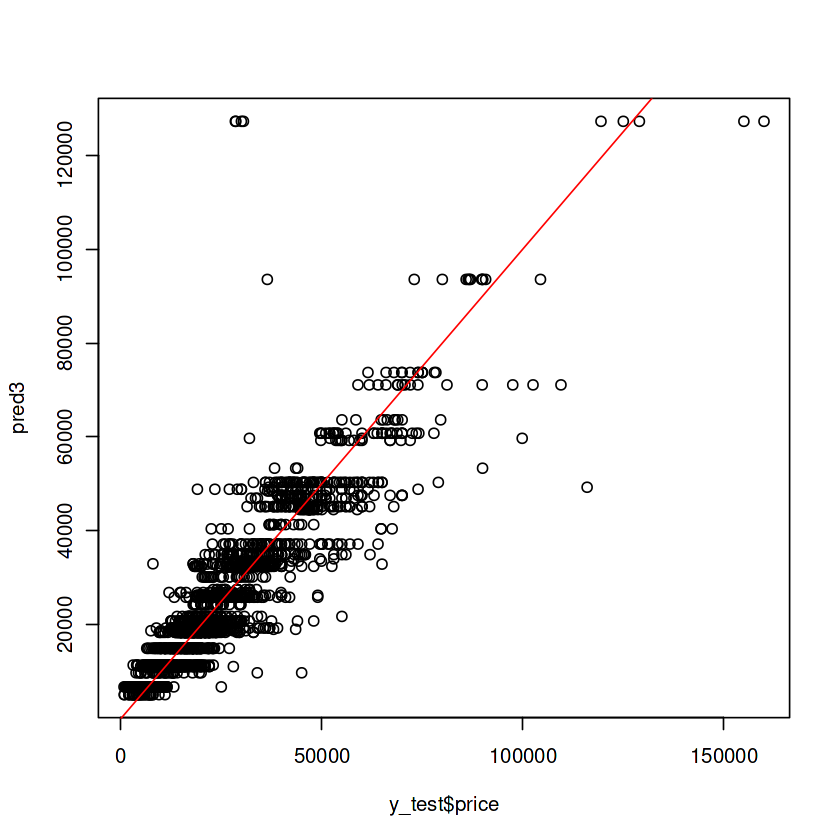

In [17]:
# windows(width=12, height=5)                    # not suitable with kaggle platform
# par(mfrow=c(1,3))

plot(y_test$price, pred1)
abline(0, 1, col = "red")
plot(y_test$price, pred2)
abline(0, 1, col = "red")
plot(y_test$price, pred3)
abline(0, 1, col = "red")

# 3. Note

Hmm …… the result from `rpart` is not a regression formula,  
but it just outputs some "countable" kinds of values.  
If I knew it, I wouldn't try cutting cp hastly.